In [1]:
import os

os.chdir("..")

In [2]:
from datasetsforecast.m4 import M4
from utilsforecast.plotting import plot_series
import pandas as pd
from models.NBeatsStackMoe import NBeatsStackMoe
from models.NBeatsMoeLags import NBeatsMoeLags
from neuralforecast import NeuralForecast
from utils import load_dataset, train_test_split
from models.callbacks.probs_collector import GateValuesCollectorCallback
from neuralforecast.losses.numpy import smape
from neuralforecast.models import NBEATS


# Load the M4 dataset
m3 = M4.load(directory='C:\\Users\\ricar\\mixture_of_experts_time_series\\data\\m4\\', group='Monthly')[0]

c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-19 16:15:33,745	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-19 16:15:33,930	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
c:\Users\ricar\mixture_of_experts_time_series\venv\Lib\site-packages\gluonts\json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
horizon = 18
input_size = 24

     data        trend     seasonal   remainder
0  8000.0  7183.418377   822.088871   -5.507248
1  8350.0  7130.019228   868.238282  351.742490
2  8570.0  7079.344217  1191.674616  298.981167
3  7700.0  7031.505837   708.103309  -39.609146
4  7080.0  6986.306143   254.136205 -160.442348


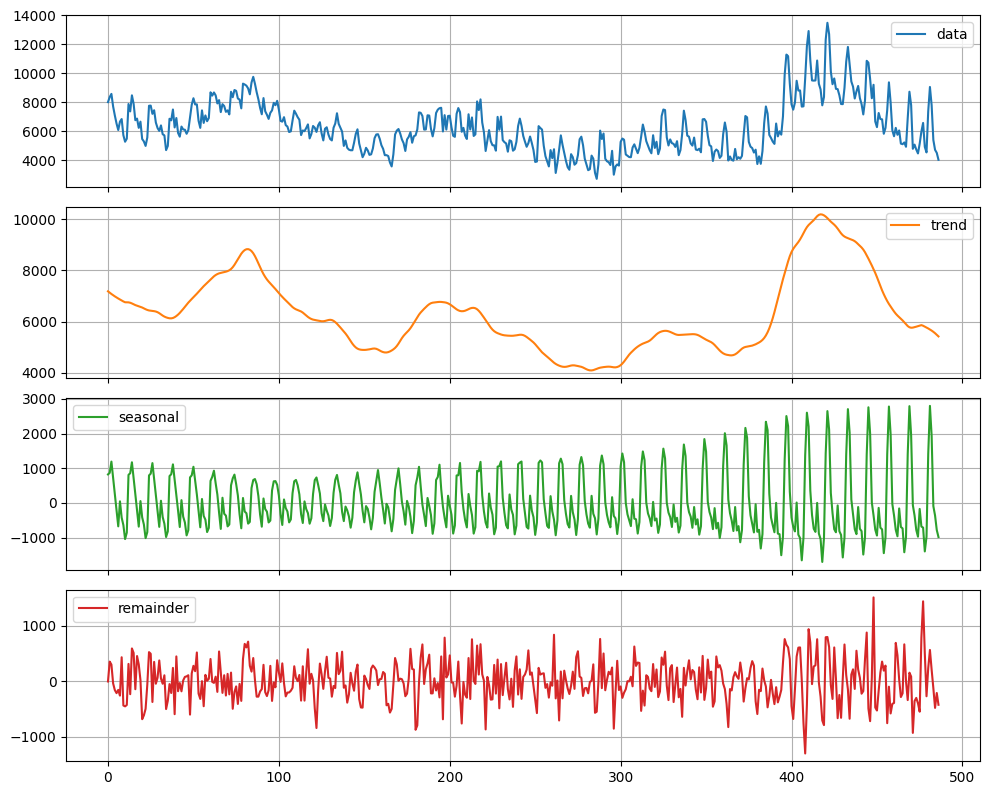

In [4]:
# decompose the time series
from statsforecast.models import MSTL
from statsforecast import StatsForecast
import matplotlib.pyplot as plt

sf =  StatsForecast(models=[MSTL(season_length=[12] )], freq="M")
sf.fit(m3)

decomposition = sf.fitted_[0, 0].model_
print(decomposition.head())

# Plot the decomposed components: observed, trend, seasonal, and remainder.
decomposition.plot(subplots=True, grid=True, figsize=(10, 8))
plt.tight_layout()
plt.show()

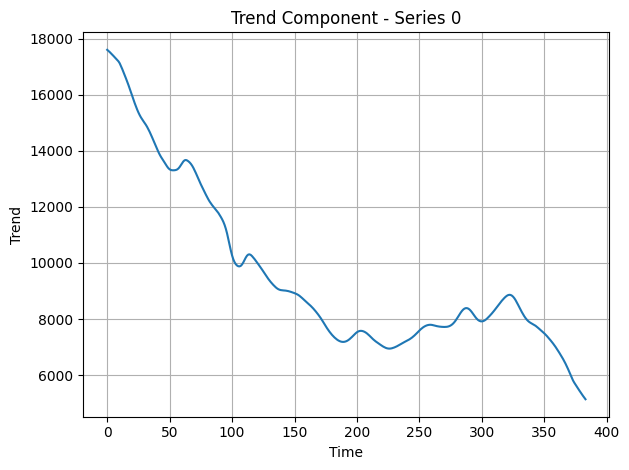

In [5]:
# Create datasets from decomposed components
trend = pd.DataFrame([sf.fitted_[i, 0].model_['trend'].values for i in range(len(sf.fitted_))])
seasonal = pd.DataFrame([sf.fitted_[i, 0].model_['seasonal'].values for i in range(len(sf.fitted_))])
remainder = pd.DataFrame([sf.fitted_[i, 0].model_['remainder'].values for i in range(len(sf.fitted_))])

# Plot the trend of the first series
plt.plot(trend.iloc[1])
plt.title("Trend Component - Series 0")
plt.xlabel("Time")
plt.ylabel("Trend")
plt.grid(True)
plt.tight_layout()
plt.show()


In [6]:
def convert_to_nixtla_format(df, component_name="trend", time_index=None):
    long_df = df.copy()
    long_df["unique_id"] = [f"series_{i}" for i in range(len(df))]
    long_df = long_df.melt(id_vars=["unique_id"], var_name="time_idx", value_name="y")


    long_df["ds"] = long_df["time_idx"].astype(int)

    long_df = long_df[["unique_id", "ds", "y"]]

    #remove nan
    long_df = long_df.dropna()
    
    return long_df

trend_ds = convert_to_nixtla_format(trend, "trend")
seasonal_ds = convert_to_nixtla_format(seasonal, "seasonal")
remainder_ds = convert_to_nixtla_format(remainder, "remainder")


In [7]:
# create test and train datasets

Y_train_trend, Y_test_trend = train_test_split(trend_ds, horizon)
Y_train_seasonal, Y_test_seasonal = train_test_split(seasonal_ds, horizon)
Y_train_remainder, Y_test_remainder = train_test_split(remainder_ds, horizon)

Y_train_trend

,unique_id,ds,y
0,series_0,0,7183.418377
1,series_0,1,7130.019228
2,series_0,2,7079.344217
3,series_0,3,7031.505837
4,series_0,4,6986.306143
...,...,...,...
10382406,series_9999,64,6936.245094
10382407,series_9999,65,6828.767237
10382408,series_9999,66,6695.072540
10382409,series_9999,67,6531.043144


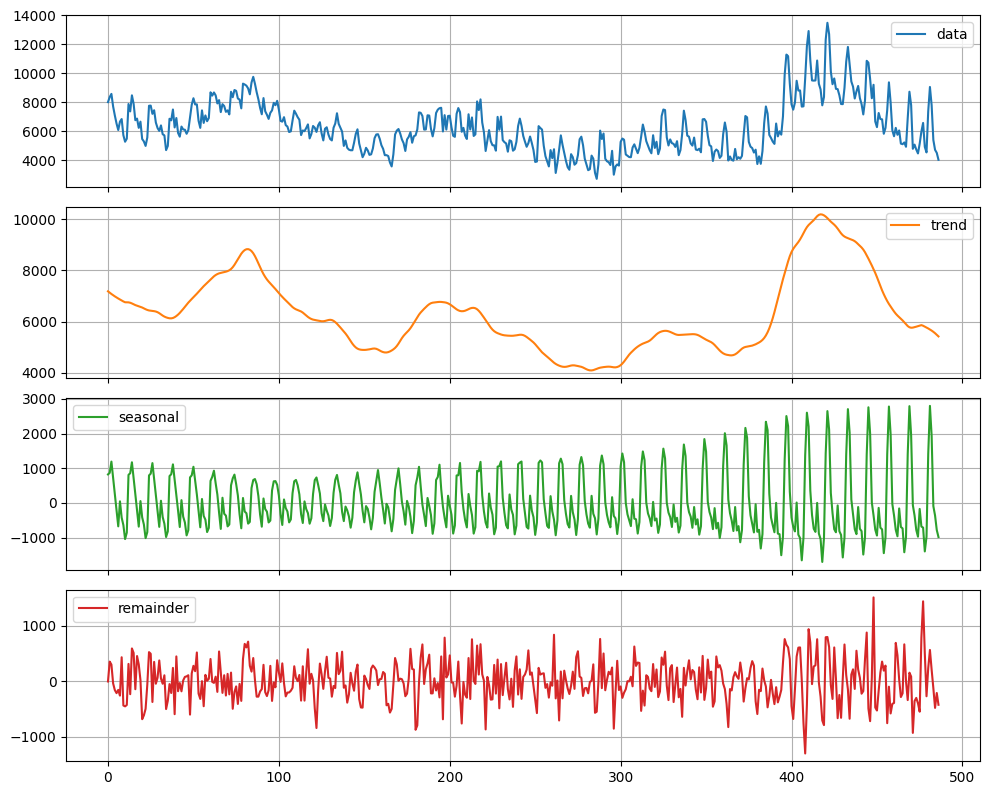

In [8]:
sf.fitted_[0, 0].model_.plot(subplots=True, grid=True, figsize=(10, 8))
plt.tight_layout()
plt.show()

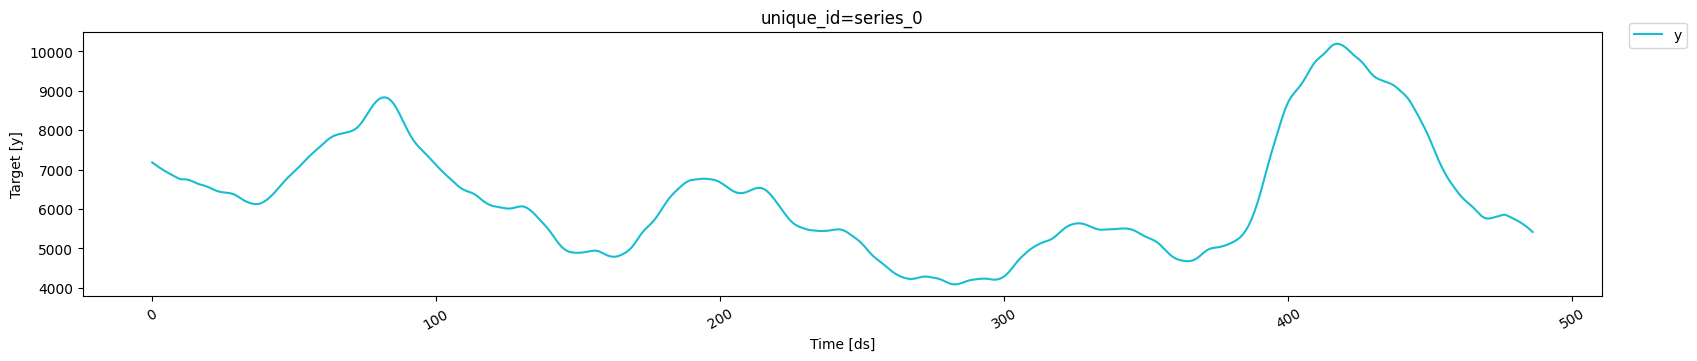

In [9]:
# plot series_0 from trend~
plot_series(Y_train_trend, Y_test_trend, ids=['series_0'])



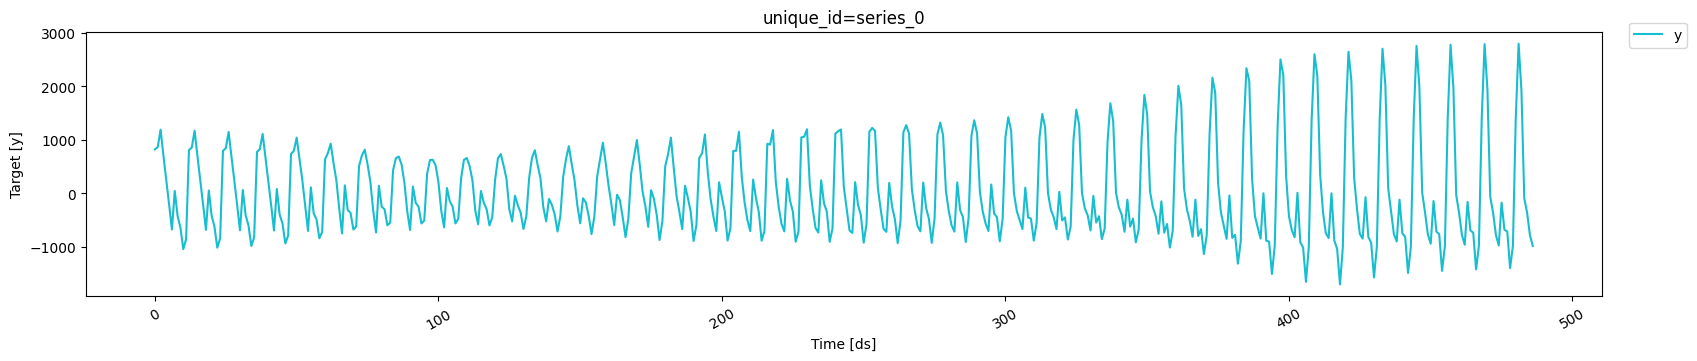

In [10]:
plot_series(Y_train_seasonal, Y_test_seasonal, ids=['series_0'])

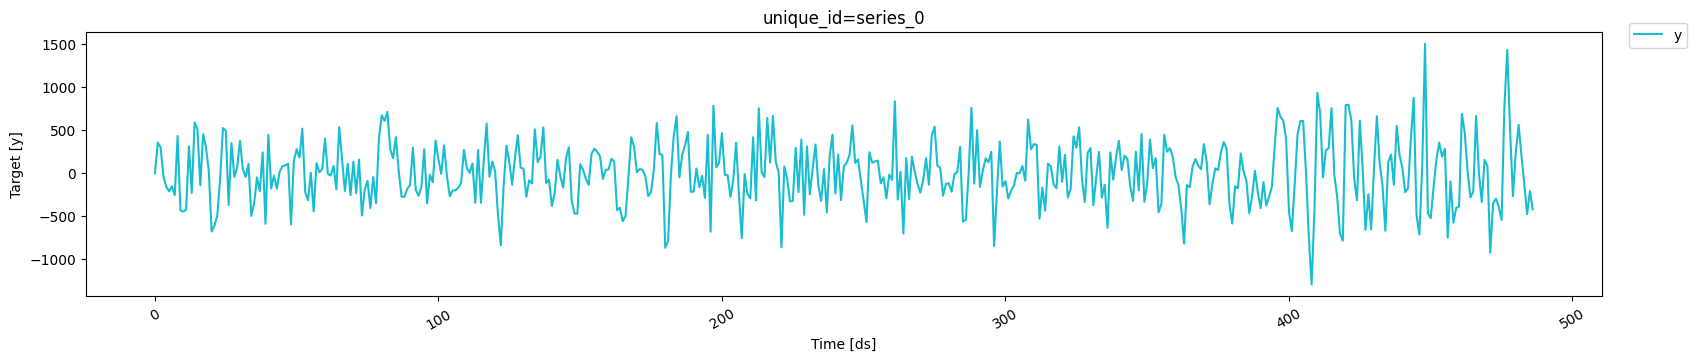

In [11]:
plot_series(Y_train_remainder, Y_test_remainder, ids=['series_0'])

In [12]:
def calculate_smape(Y_test_df, Y_hat_df, forecast_col):
    """Calculate the sMAPE."""
    y_true = Y_test_df['y'].values
    try:
        y_hat = Y_hat_df[forecast_col].values
    except KeyError as exc:
        raise KeyError(
            f"Forecast column '{forecast_col}' not found in predictions!") from exc
   
    n_series = Y_test_df['unique_id'].nunique()
    try:
        y_true = y_true.reshape(n_series, -1)
        y_hat = y_hat.reshape(n_series, -1)
    except Exception as e:
        raise ValueError("Error reshaping arrays") from e

    return smape(y_true, y_hat)

First lets train on the m3 ...

In [13]:
m3['ds'] = m3.groupby('unique_id').cumcount()

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 642 K  | train
4 | gate         | Sequential    | 123    | train
-------------------------------------------------------
641 K     Trainable params
1.6 K     Non-trainable params
642 K     Total params
2.571     Total estimated model params size (MB)
34        Modules in train mode

Epoch 0:  67%|██████▋   | 1000/1500 [03:19<01:39,  5.01it/s, v_num=502, train_loss_step=434.0, valid_loss=515.0, train_loss_epoch=400.0]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 0:  67%|██████▋   | 1000/1500 [03:19<01:39,  5.01it/s, v_num=502, train_loss_step=434.0, valid_loss=515.0, train_loss_epoch=400.0]


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1500/1500 [00:10<00:00, 138.90it/s]
all_gates_cat shape: torch.Size([48000, 3])

mean inputs_cat:  tensor([0.3250, 0.3834, 0.2916], device='cuda:0')

num_experts: tensor([8136, 9703,   48], device='cuda:0')

Best expert counts: tensor([18164, 27152,  2684], device='cuda:0')


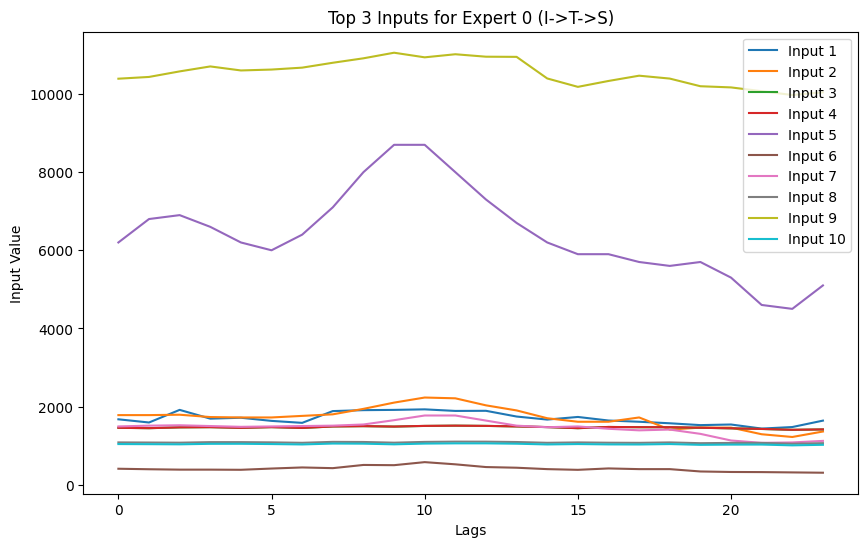

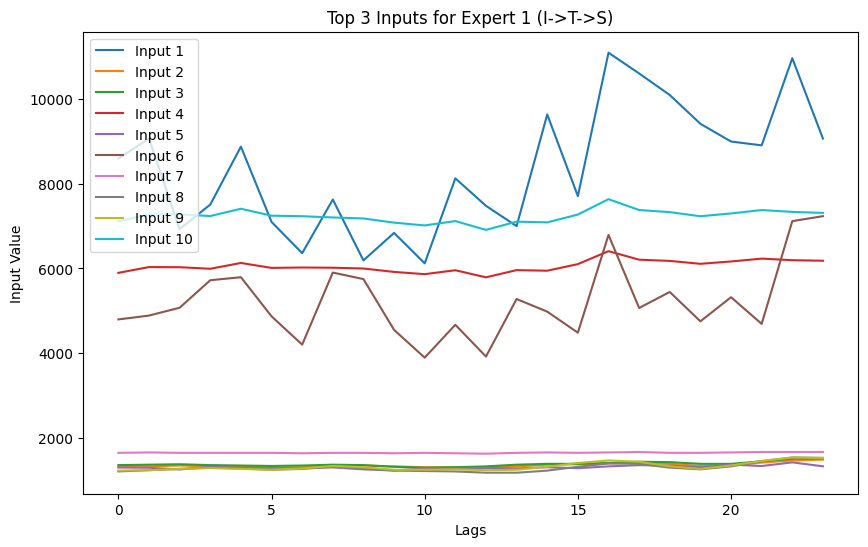

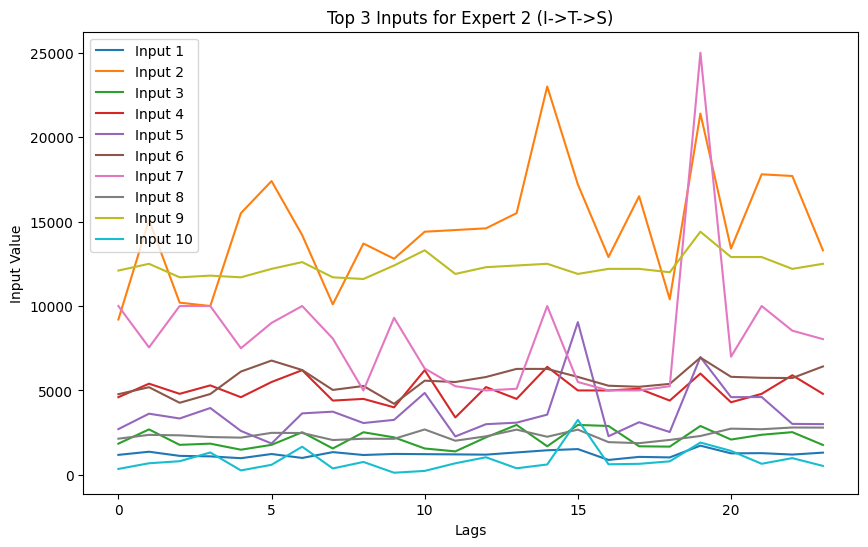

Resetting gate values for next epoch.
Predicting DataLoader 0: 100%|██████████| 1500/1500 [00:11<00:00, 131.94it/s]
sMAPE for original: 0.12956027731361727


In [14]:
y_train, y_test = train_test_split(m3, horizon)

prob_collector = GateValuesCollectorCallback(is_stack=True, reset_on_epoch=True)
nf = NeuralForecast(
    models=[
        NBeatsStackMoe(
            input_size=input_size, 
            h=horizon,
            mlp_units = 3 * [[256, 256]],
            callbacks=[prob_collector],
            # n_blocks = [3, 3, 3],
        )
    ], 
    freq=1
)
nf.fit(df=y_train, static_df=None, val_size=horizon)
predictions = nf.predict(futr_df=y_test)

smape_original = calculate_smape(y_test, predictions, 'NBeatsStackMoe')
print(f'sMAPE for original: {smape_original}')

Now lets test on the trend test and train ... 

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1500/1500 [00:10<00:00, 139.79it/s]
all_gates_cat shape: torch.Size([48000, 3])

mean inputs_cat:  tensor([0.3127, 0.3968, 0.2906], device='cuda:0')

num_experts: tensor([10844, 17595,     0], device='cuda:0')

Best expert counts: tensor([18954, 29013,    33], device='cuda:0')


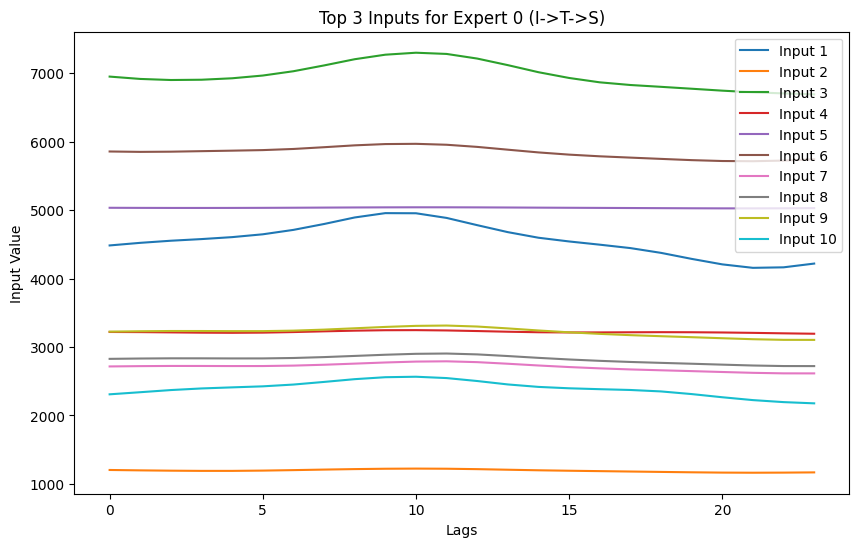

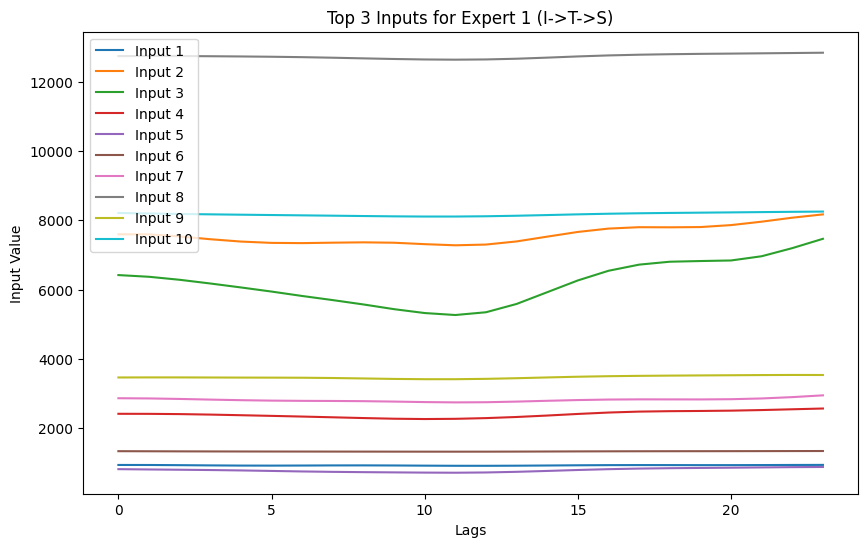

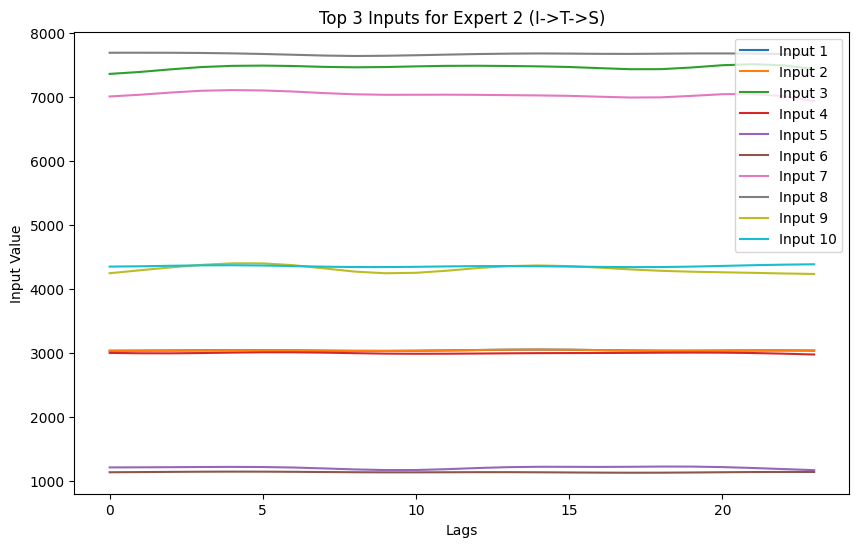

Resetting gate values for next epoch.
Predicting DataLoader 0: 100%|██████████| 1500/1500 [00:11<00:00, 132.41it/s]


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1500/1500 [00:12<00:00, 124.57it/s]
all_gates_cat shape: torch.Size([48000, 3])

mean inputs_cat:  tensor([0.3156, 0.3953, 0.2891], device='cuda:0')

num_experts: tensor([12336, 18541,     0], device='cuda:0')

Best expert counts: tensor([18967, 29003,    30], device='cuda:0')


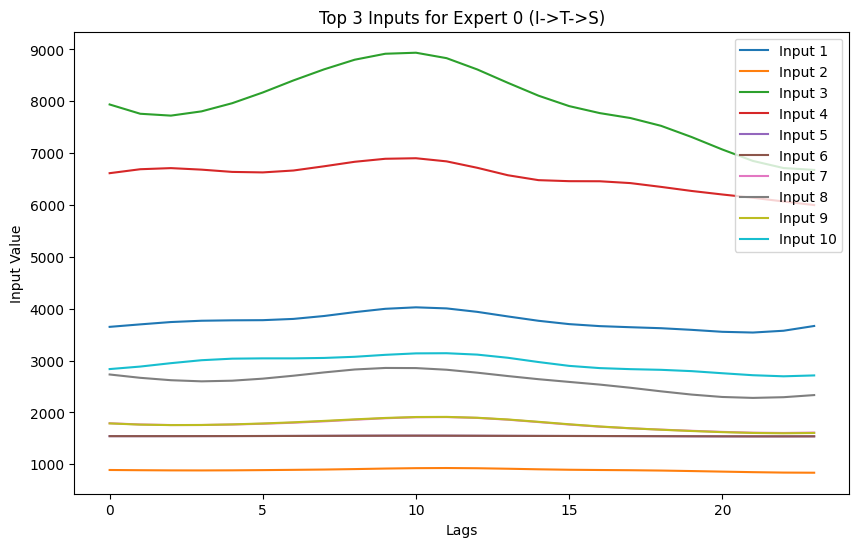

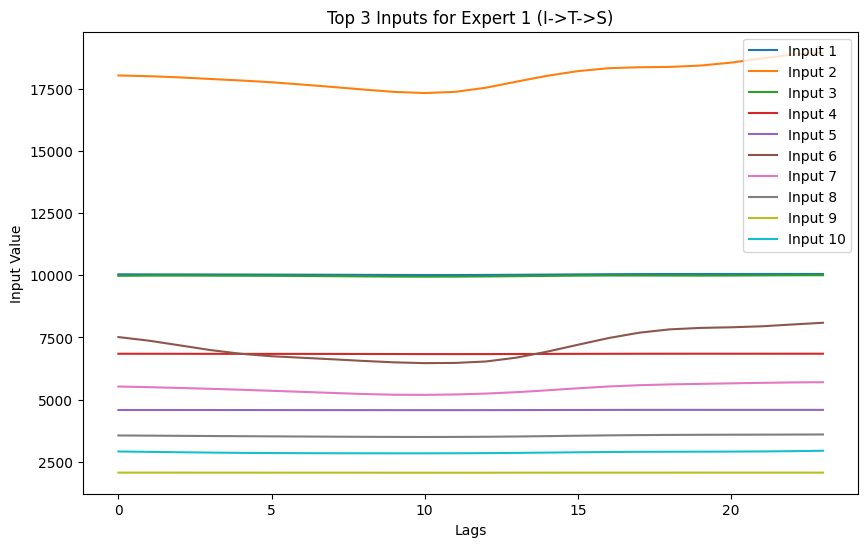

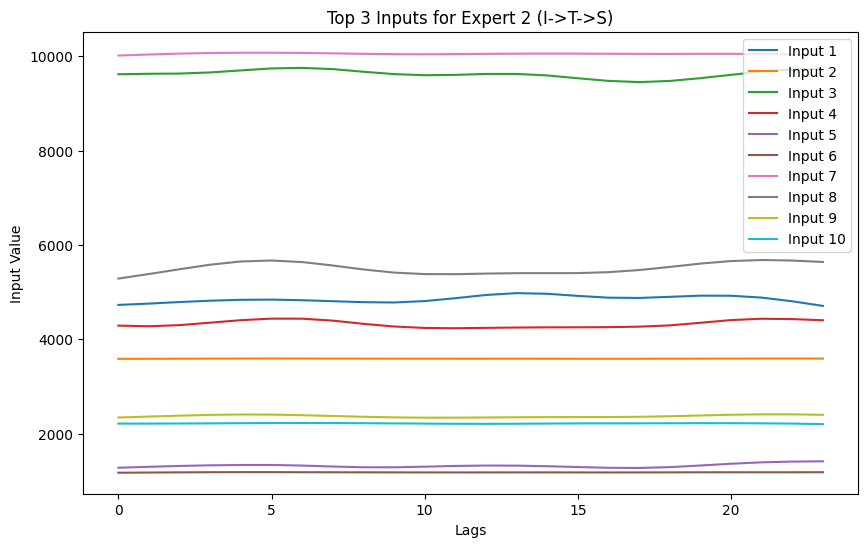

Resetting gate values for next epoch.
Predicting DataLoader 0: 100%|██████████| 1500/1500 [00:12<00:00, 118.42it/s]
sMAPE for trend train: 0.06848640147198776
sMAPE for trend test: 0.07655854068493366


In [15]:
# test on the trend component
y_train_t, y_test_t = train_test_split(Y_train_trend, horizon)

pred_train_trend = nf.predict(df=y_train_t, futr_df=y_test_t)
pred_test_trend = nf.predict(df= Y_train_trend, futr_df=Y_test_trend)

smape_train_trend = calculate_smape(y_test_t, pred_train_trend, 'NBeatsStackMoe')
smape_test_trend = calculate_smape(Y_test_trend, pred_test_trend, 'NBeatsStackMoe')
print(f'sMAPE for trend train: {smape_train_trend}')
print(f'sMAPE for trend test: {smape_test_trend}')

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1500/1500 [00:11<00:00, 132.39it/s]
all_gates_cat shape: torch.Size([48000, 3])

mean inputs_cat:  tensor([0.3116, 0.3850, 0.3034], device='cuda:0')

num_experts: tensor([959, 480,  10], device='cuda:0')

Best expert counts: tensor([12511, 30455,  5034], device='cuda:0')


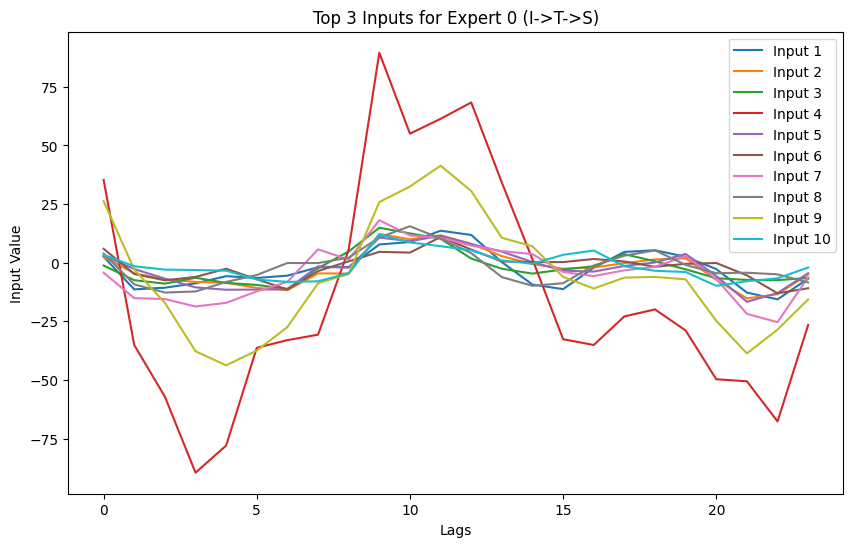

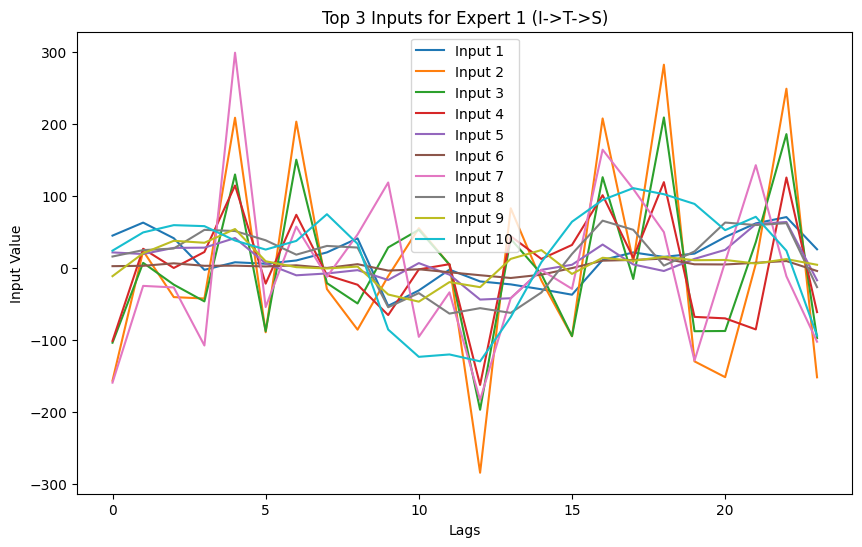

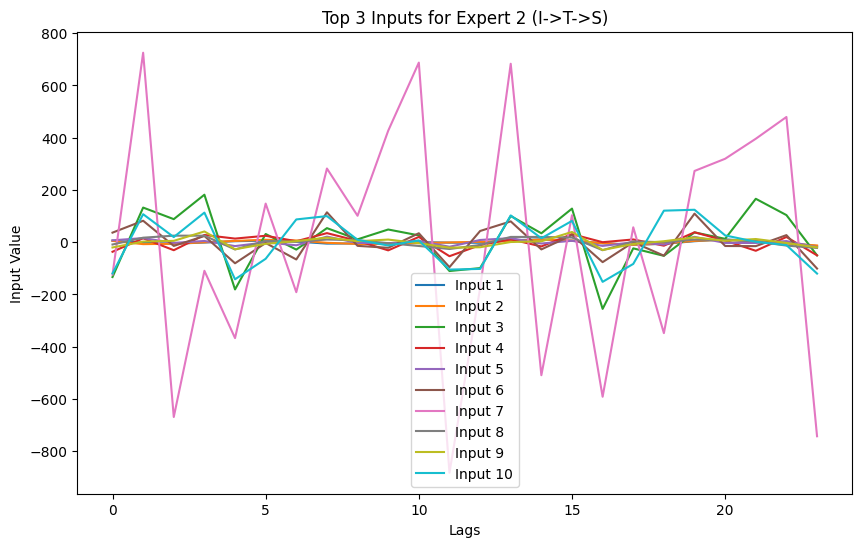

Resetting gate values for next epoch.
Predicting DataLoader 0: 100%|██████████| 1500/1500 [00:11<00:00, 126.21it/s]


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1500/1500 [00:11<00:00, 133.61it/s]
all_gates_cat shape: torch.Size([48000, 3])

mean inputs_cat:  tensor([0.3374, 0.3671, 0.2955], device='cuda:0')

num_experts: tensor([1025,  115,    4], device='cuda:0')

Best expert counts: tensor([19403, 23926,  4671], device='cuda:0')


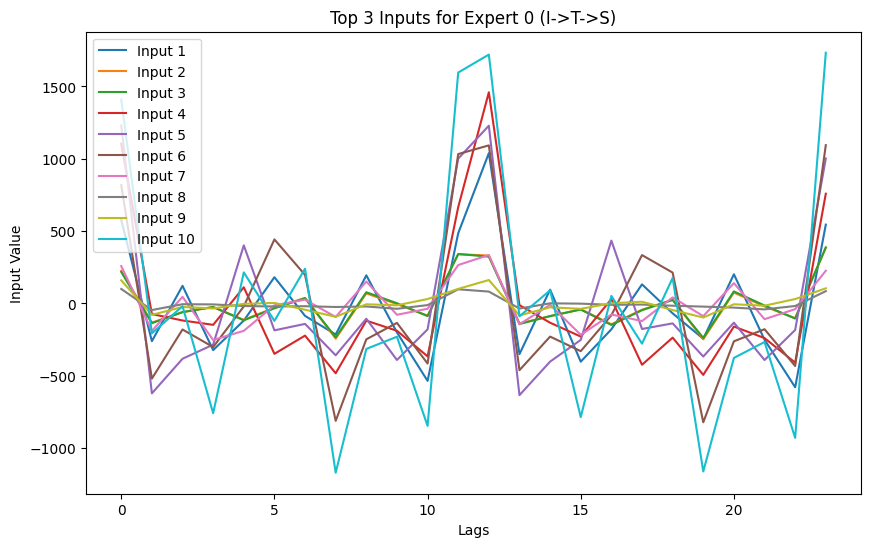

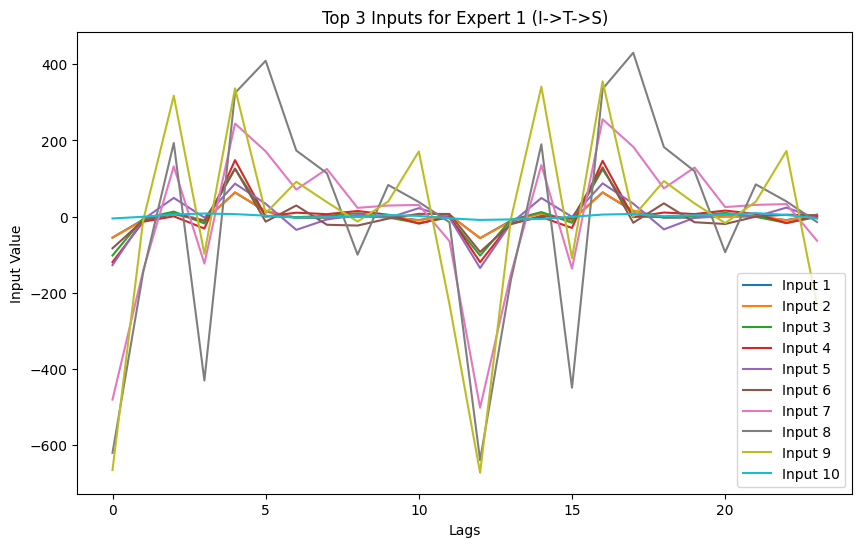

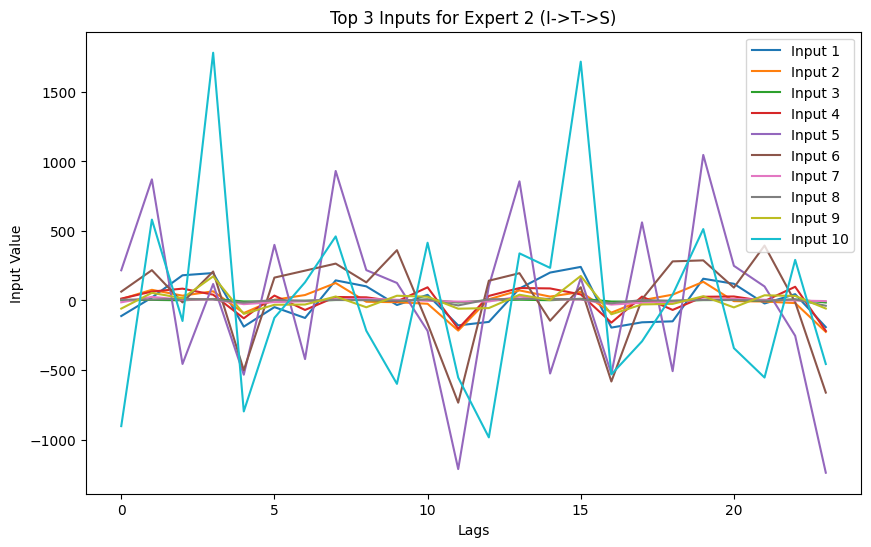

Resetting gate values for next epoch.
Predicting DataLoader 0: 100%|██████████| 1500/1500 [00:11<00:00, 127.54it/s]
sMAPE for seasonal train: 1.123905254914402
sMAPE for seasonal test: 1.056997853306191


In [16]:
# test on the seasonal component
y_train_s, y_test_s = train_test_split(Y_train_seasonal, horizon)


pred_train_seasonal = nf.predict(df=y_train_s, futr_df=y_test_s)
pred_test_seasonal = nf.predict(df=Y_train_seasonal, futr_df=Y_test_seasonal)

smape_train_seasonal = calculate_smape(y_test_s, pred_train_seasonal, 'NBeatsStackMoe')
smape_test_seasonal = calculate_smape(Y_test_seasonal, pred_test_seasonal, 'NBeatsStackMoe')
print(f'sMAPE for seasonal train: {smape_train_seasonal}')
print(f'sMAPE for seasonal test: {smape_test_seasonal}')

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1500/1500 [00:11<00:00, 129.40it/s]
all_gates_cat shape: torch.Size([48000, 3])

mean inputs_cat:  tensor([0.3323, 0.3654, 0.3023], device='cuda:0')

num_experts: tensor([5054, 3606,  375], device='cuda:0')

Best expert counts: tensor([18021, 22181,  7798], device='cuda:0')


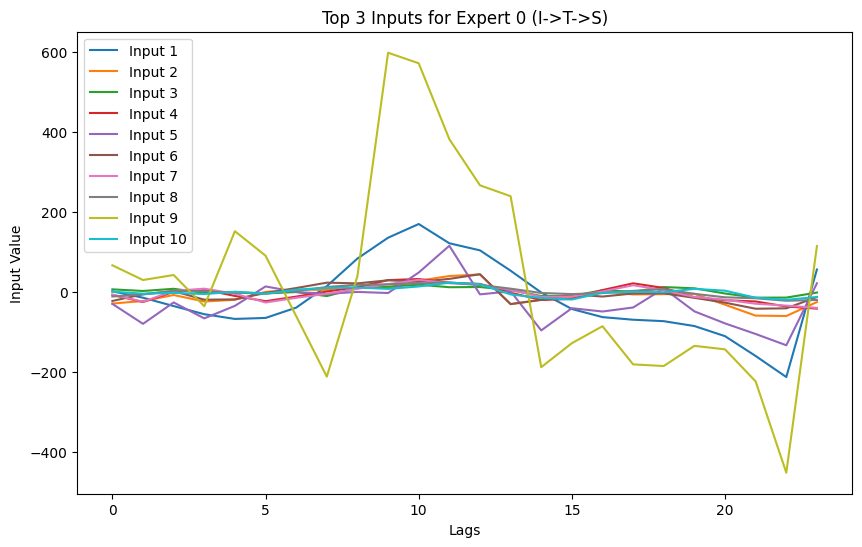

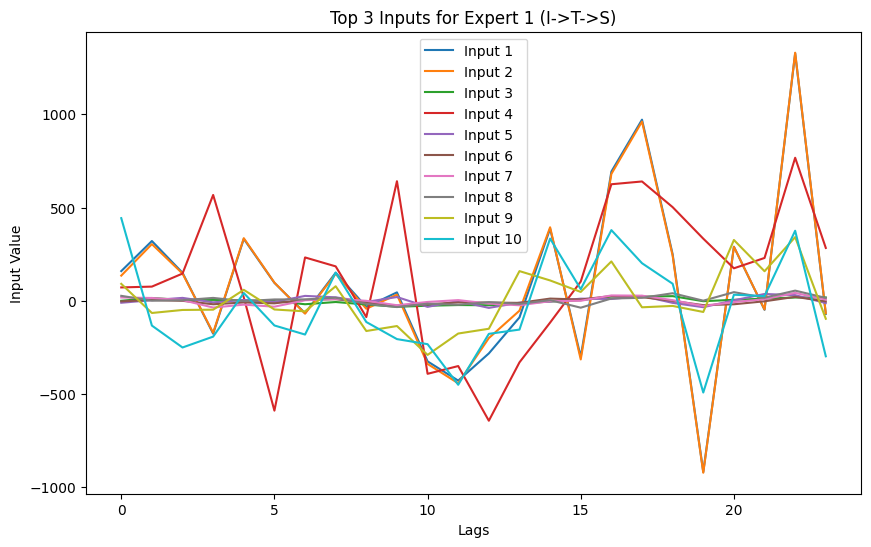

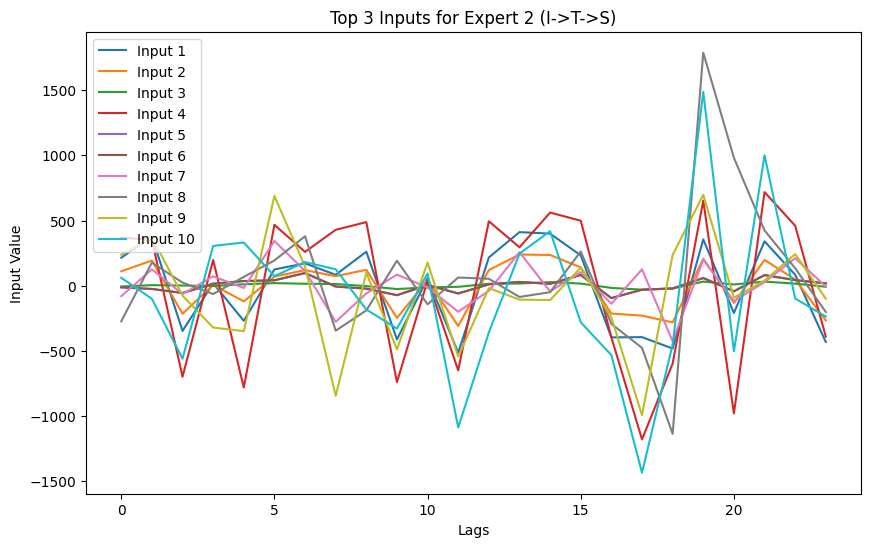

Resetting gate values for next epoch.
Predicting DataLoader 0: 100%|██████████| 1500/1500 [00:12<00:00, 123.54it/s]


INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1500/1500 [00:11<00:00, 125.66it/s]
all_gates_cat shape: torch.Size([48000, 3])

mean inputs_cat:  tensor([0.3272, 0.3690, 0.3038], device='cuda:0')

num_experts: tensor([4630, 3896,  350], device='cuda:0')

Best expert counts: tensor([17300, 22835,  7865], device='cuda:0')


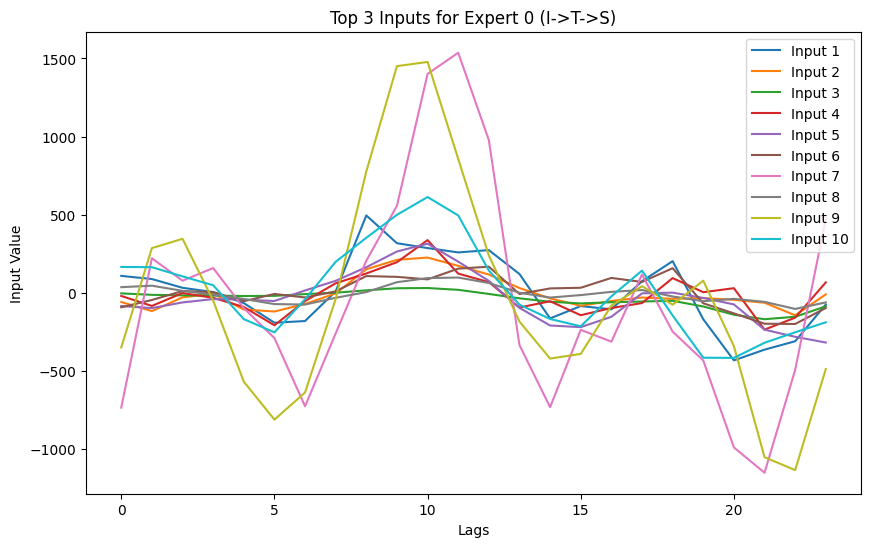

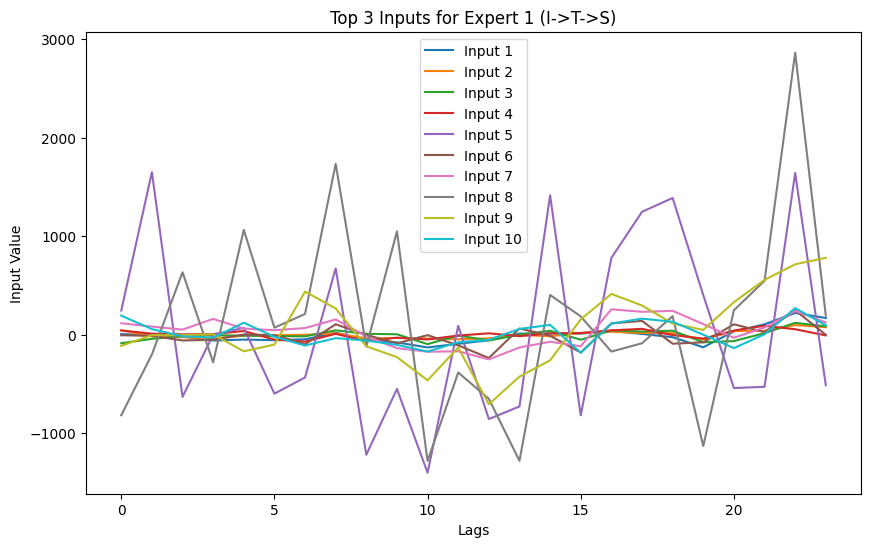

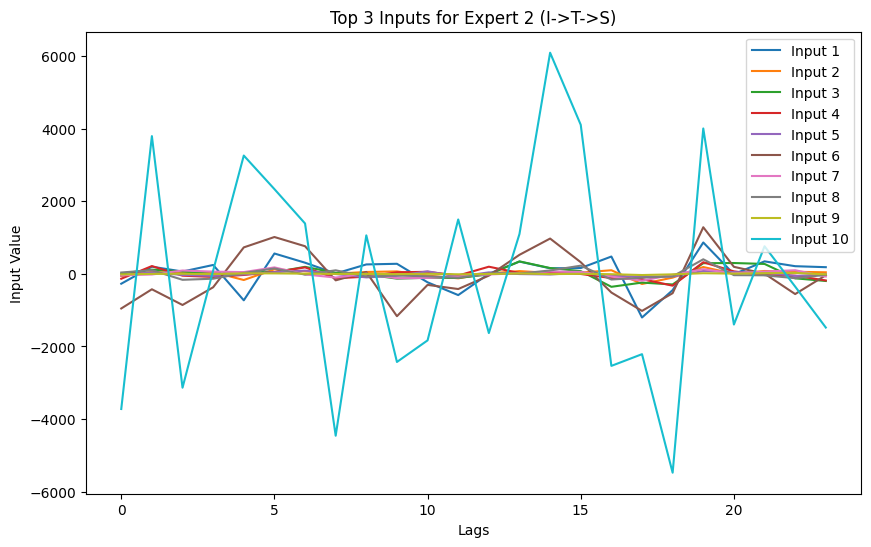

Resetting gate values for next epoch.
Predicting DataLoader 0: 100%|██████████| 1500/1500 [00:12<00:00, 119.06it/s]
sMAPE for remainder train: 1.4855649351770817
sMAPE for remainder test: 1.4869587956749366


In [17]:
# Test on the remainder component
y_train_r, y_test_r = train_test_split(Y_train_remainder, horizon)

pred_train_remainder = nf.predict(df=y_train_r, futr_df=y_test_r)
pred_test_remainder = nf.predict(df=Y_train_remainder, futr_df=Y_test_remainder)

smape_train_remainder = calculate_smape(y_test_r, pred_train_remainder, 'NBeatsStackMoe')
smape_test_remainder = calculate_smape(Y_test_remainder, pred_test_remainder, 'NBeatsStackMoe')
print(f'sMAPE for remainder train: {smape_train_remainder}')
print(f'sMAPE for remainder test: {smape_test_remainder}')

Now working with synthetic data

In [18]:
import numpy as np
# Parameters
n_series = 200         # Number of unique time series
length = input_size * 5 + horizon         # Length of each series
noise_std = 0.1       # Noise level

# Container for all series
dfs = []

for i in range(n_series):
    amplitude = np.random.uniform(8, 10)  # Random amplitude for variation
    freq = 1 / np.random.randint(20, 140)  # Random frequency for variation
    phase = np.random.rand() * 2 * np.pi  # Random phase shift
    x = np.arange(length)
    y = amplitude * np.sin(2 * np.pi * freq * x + phase) + np.random.normal(0, noise_std, length)
    
    df_i = pd.DataFrame({
        'unique_id': f'series_{i}',
        'ds': x,
        'y': y
    })
    dfs.append(df_i)

# Combine into one DataFrame
df_synte = pd.concat(dfs).reset_index(drop=True)

df_synte


,unique_id,ds,y
0,series_0,0,1.429493
1,series_0,1,1.890170
2,series_0,2,2.138536
3,series_0,3,2.873647
4,series_0,4,3.384011
...,...,...,...
27595,series_199,133,6.001519
27596,series_199,134,6.459507
27597,series_199,135,7.115762
27598,series_199,136,7.507049


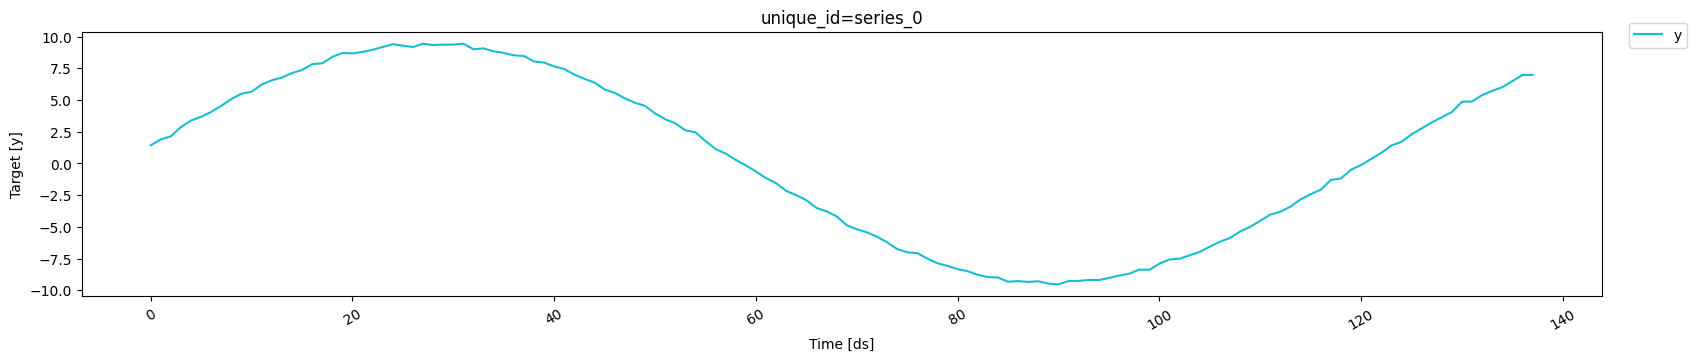

In [19]:
plot_series(df_synte, ids=['series_0'])

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 142.97it/s]
all_gates_cat shape: torch.Size([200, 3])

mean inputs_cat:  tensor([0.3463, 0.3705, 0.2832], device='cuda:0')

num_experts: tensor([62, 63,  0], device='cuda:0')

Best expert counts: tensor([ 96, 104,   0], device='cuda:0')


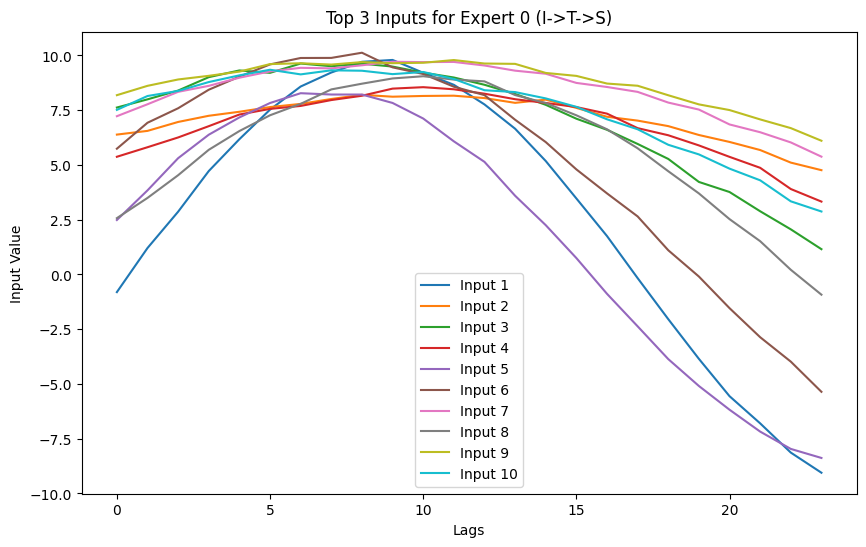

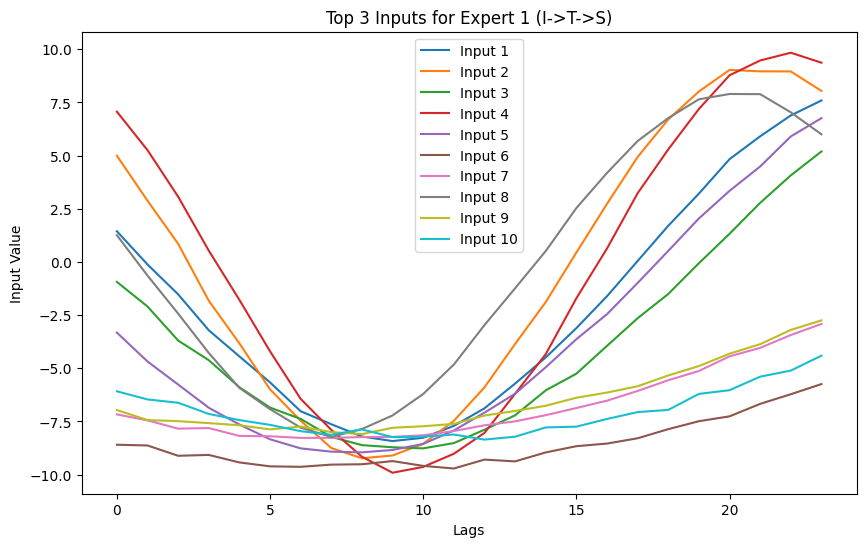

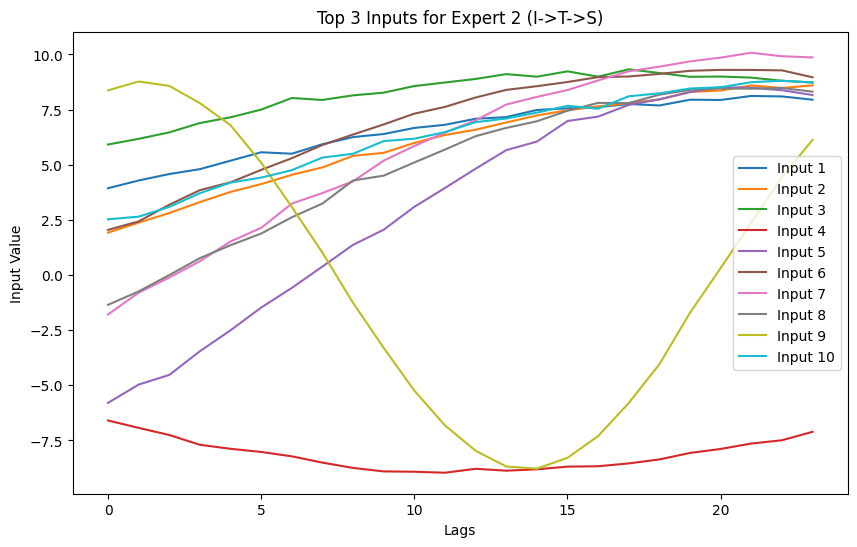

Resetting gate values for next epoch.
Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 11.83it/s] 
sMAPE for season synt test: 1.138611258204341


In [20]:
# Test on the remainder component
y_train_s_syn, y_test_s_syn = train_test_split(df_synte, horizon)

pred_train_s_syn = nf.predict(df=y_train_s_syn, futr_df=y_test_s_syn)

smape_test_s_syn = calculate_smape(y_test_s_syn, pred_train_s_syn, 'NBeatsStackMoe')
print(f'sMAPE for season synt test: {smape_test_s_syn}')

...now for trend...

In [21]:
import numpy as np
import pandas as pd

# Parameters
n_series = 200         # Number of unique time series
length = input_size * 5 + horizon         # Length of each series

# Collect all series
dfs = []

for i in range(n_series):
    noise_std = np.random.uniform(100.0, 200.0)       # Increased noise level
    x = np.arange(length)
    
    # Random linear or polynomial trend with larger changes
    slope = np.random.uniform(1, 200.0)   # Steeper slopes
    intercept = np.random.uniform(0, 5000)
    poly_degree = np.random.choice([1, 2])  # Linear or quadratic
    
    if poly_degree == 1:
        y = slope * x + intercept
    else:
        a = np.random.uniform(-0.01, 0.01)  # Larger quadratic coefficient
        y = a * x**2 + slope * x + intercept
    
    # Add noise
    y += np.random.normal(0, noise_std, length)
    
    # Assemble into DataFrame
    df_i = pd.DataFrame({
        'unique_id': f'series_{i}',
        'ds': x,
        'y': y
    })
    dfs.append(df_i)

# Combine all
df_synte_t = pd.concat(dfs).reset_index(drop=True)

df_synte_t


,unique_id,ds,y
0,series_0,0,668.996174
1,series_0,1,526.582902
2,series_0,2,711.623059
3,series_0,3,903.374970
4,series_0,4,958.965487
...,...,...,...
27595,series_199,133,11333.111353
27596,series_199,134,11342.058274
27597,series_199,135,11331.724868
27598,series_199,136,11416.948689


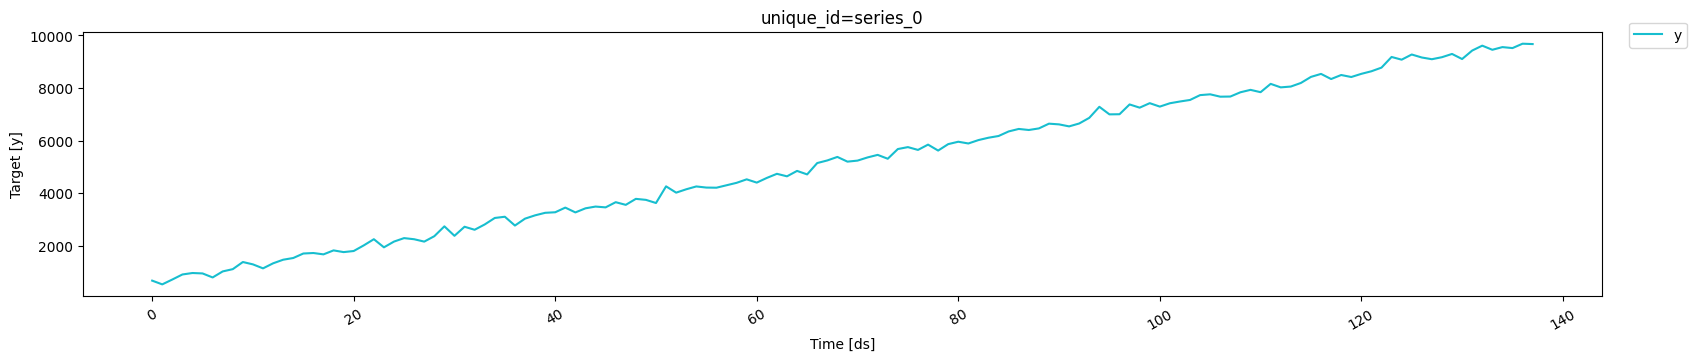

In [22]:
plot_series(df_synte_t, ids=['series_0'])

INFO:pytorch_lightning.utilities.rank_zero:Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 127.09it/s]
all_gates_cat shape: torch.Size([200, 3])

mean inputs_cat:  tensor([0.1682, 0.5106, 0.3212], device='cuda:0')

num_experts: tensor([  0, 154,   0], device='cuda:0')

Best expert counts: tensor([  1, 196,   3], device='cuda:0')


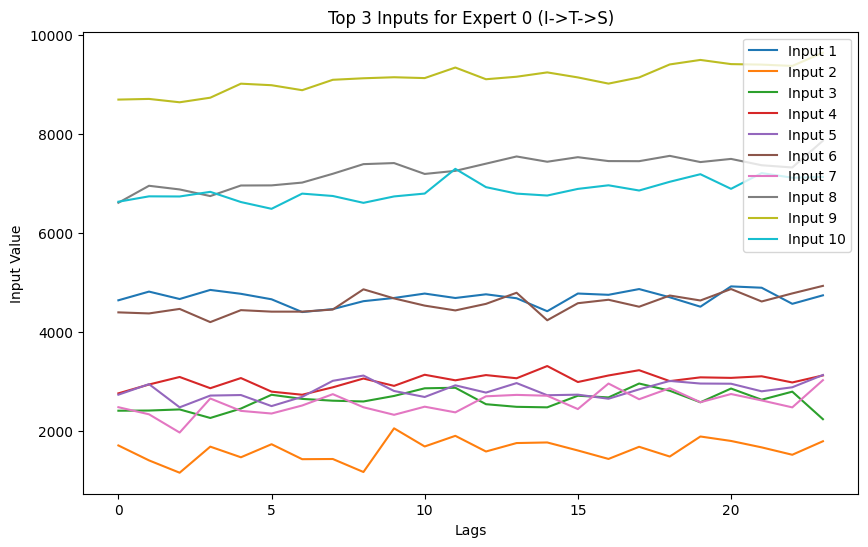

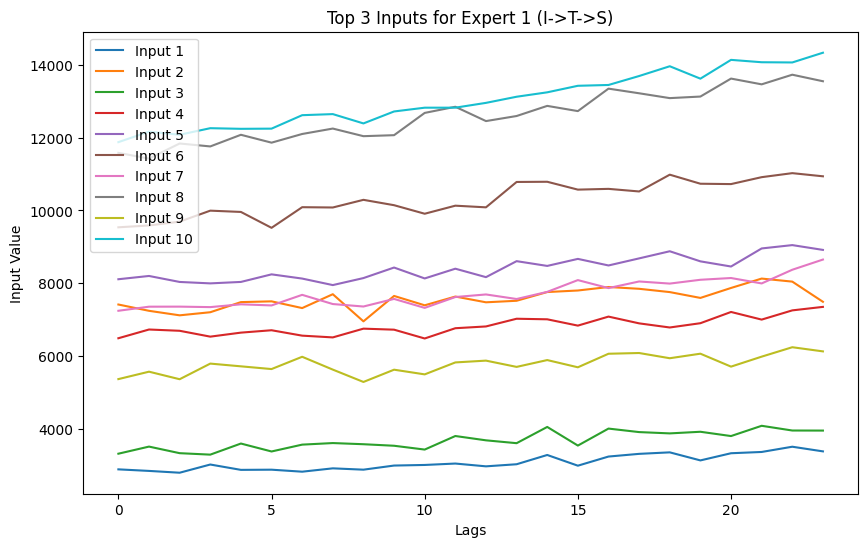

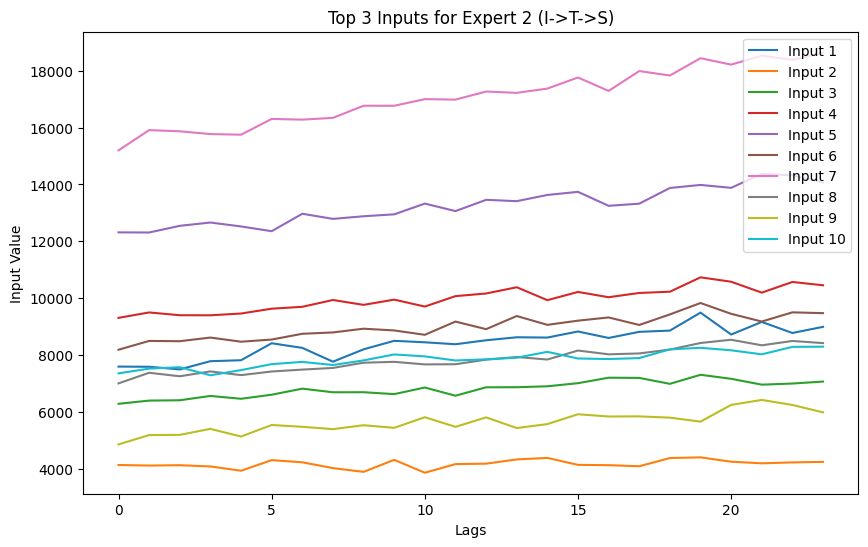

Resetting gate values for next epoch.
Predicting DataLoader 0: 100%|██████████| 7/7 [00:00<00:00, 12.35it/s] 
sMAPE for trend synt test: 0.03690958661447326


In [23]:
# Test on the remainder component
y_train_t_syn, y_test_t_syn = train_test_split(df_synte_t, horizon)

pred_train_t_syn = nf.predict(df=y_train_t_syn, futr_df=y_test_t_syn)

smape_test_t_syn = calculate_smape(y_test_t_syn, pred_train_t_syn, 'NBeatsStackMoe')
print(f'sMAPE for trend synt test: {smape_test_t_syn}')